# Проект 4. Компьютер говорит 'Нет'

# 1. Подключаем библиотеки

In [1222]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from itertools import combinations
from scipy.stats import ttest_ind
import statsmodels.api as sm
import scipy.stats as sst
import warnings
from datetime import datetime

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
%matplotlib inline

/kaggle/input/sf-dst-scoring/sample_submission.csv
/kaggle/input/sf-dst-scoring/test.csv
/kaggle/input/sf-dst-scoring/train.csv


# 2. Определяем классы и функции

In [1223]:
class LogDf(): # класс логарифмирования признака
    def __init__(self, df, col):
        self.df = df
        self.col = col
        self.col_log = col + '_log'
        
    def df_col_log(self):      
        return  self.df[self.col].apply(lambda x: np.log(x + 1)) 

class NumFitInspect(): # класс для построения визуализация для числового признака и нахождения выбросов.
    def __init__(self, df, col):
        self.df = df[col]
        self.col = col
        self.col_log = LogDf(df, col).col_log
        self.df_log = LogDf(df, col).df_col_log()
    
    def show_plots(self, size = 5, log = False): # графики
        
        if log:
            data = self.df_log
            column = self.col_log
        else:
            data = self.df
            column = self.col
        
        f = plt.figure()
        f.clear()
        plt.close(f)

        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (3*size,size))

        fig = sm.qqplot(data.dropna(), fit = True, line ='45', ax=ax1) # сравнение с нормальным распределением
        fig.suptitle('QQ-plot, histogram and boxplot for {0} '.format(column))
        
        ax2.hist(data.dropna(), bins = 20, histtype = 'bar', align = 'mid', rwidth = 0.8, color = 'green') # гистограмма
        ax3.boxplot(data.dropna(), vert = False)  # выбросы
     
        plt.show
        
    def boundaries(self, log = False): # границы выбросов
        if log:
            data = self.df_log
            column = self.col_log
        else:
            data = self.df
            column = self.col
        
        q1 = data.quantile(q = 0.25) 
        q3 = data.quantile(q = 0.75) 
        IQR = q3 - q1
        return q1 - 1.5*IQR, q3 + 1.5*IQR

    def outliers(self, log = False): # общее количество выбросов
        if log:
            data = self.df_log
            column = self.col_log
        else:
            data = self.df
            column = self.col

        minb, maxb = self.boundaries(log)
        return len(data[data < minb])+ len(data[data > maxb])


In [1224]:
class ModelInspect(): # класс для оценки метрик модели
    def __init__(self, model, X_test, y_test):
        self.X_test = X_test
        self.y_test = y_test
        self.y_pred = model.predict(X_test)
        self.probs = model.predict_proba(X_test)[:,1]
    
    def roc_curve_plot(self):
        fpr, tpr, threshold = roc_curve(self.y_test, self.probs)
        roc_auc = roc_auc_score(self.y_test, self.probs)

        plt.figure()
        plt.plot([0, 1], label='Baseline', linestyle='--')
        plt.plot(fpr, tpr, label = 'Regression')
        plt.title('Logistic Regression ROC AUC = %0.10f' % roc_auc)
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.legend(loc = 'lower right')
        plt.show()
    
    def confusion_matrix_plot(self):
        tn, fp, fn, tp = confusion_matrix(self.y_test, self.y_pred).ravel()
        cf_matrix = np.array([[tp,fp],[fn,tn]])
        group_names = ['TP','FP','FN','TN']
        group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
        labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names,group_counts)]
        labels = np.asarray(labels).reshape(2,2)
        plt.figure()
        sns.heatmap(cf_matrix, annot=labels, annot_kws={"size": 20}, fmt='', cmap= 'Pastel1', cbar = False, \
                 xticklabels = ['Дефолт','Не дефолт'], yticklabels= ['Дефолт','Не дефолт'])
        plt.title('Матрица ошибок для default')
        plt.show()
        
    def get_metrics(self):
        result = pd.Series({
            'accuracy' : accuracy_score(self.y_test, self.y_pred),
            'precision' : precision_score(self.y_test, self.y_pred),
            'recall' : recall_score(self.y_test, self.y_pred),
            'F1' : f1_score(self.y_test, self.y_pred),
            'ROC_AUC': roc_auc_score(self.y_test, self.probs) 
        })
        return result
    
    def recall_precision_plot(self):
        precisions, recalls, _ = precision_recall_curve(self.y_test, self.y_pred)
        ap = average_precision_score(self.y_test, self.y_pred)        
        
        plt.figure()
        
        plt.step(recalls, precisions, color='b', alpha=0.2, where='post')
        plt.fill_between(recalls, precisions, step='post', alpha=0.2, color='lime')
        plt.xlabel('Recall');
        plt.ylabel('Precision');
        plt.title('Recall-precision curve, площадь под кривой = %0.10f' % ap)
        plt.grid(True)

        plt.show()
                                          


# 3. Импортируем данные

In [1225]:
data_directory = '/kaggle/input/sf-dst-scoring/'
data_train = pd.read_csv(data_directory+'train.csv')
data_test = pd.read_csv(data_directory+'test.csv')
sample_submission = pd.read_csv(data_directory+'/sample_submission.csv')

In [1226]:
# зафиксируем константы
!pip freeze > requirements.txt
RANDOM_SEED = 42
CURRENT_DATE = datetime.now()

In [1227]:
# для корректной обработки признаков объединяем трейн и тест в один датасет
data_train['Train'] = 1 # помечаем где у нас трейн
data_test['Train'] = 0 # помечаем где у нас тест

data = data_train.append(data_test, sort=False).reset_index(drop=True) # объединяем

In [1228]:
print('размерность тренировочного датасета: ', data_train.shape, '\n')
print('размерность тестовго датасета: ', data_test.shape)

размерность тренировочного датасета:  (73799, 20) 

размерность тестовго датасета:  (36349, 19)


In [1229]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

Описания полей датасета

- client_id - идентификатор клиента
- education - уровень образования
- sex - пол заемщика
- age - возраст заемщика
- car - флаг наличия автомобиля
- car_type - флаг автомобиля иномарки
- decline_app_cnt - количество отказанных прошлых заявок
- good_work - флаг наличия “хорошей” работы
- bki_request_cnt - количество запросов в БКИ
- home_address - категоризатор домашнего адреса
- work_address - категоризатор рабочего адреса
- income - доход заемщика
- foreign_passport - наличие загранпаспорта
- sna - связь заемщика с клиентами банка
- first_time - давность наличия информации о заемщике
- score_bki - скоринговый балл по данным из БКИ
- region_rating - рейтинг региона
- app_date - дата подачи заявки
- default - флаг дефолта по кредиту

В тренировочном наборе 73799 записей, в тестовой - 36349. Всего 19 переменных (18 признаков + целевая).

# 4. Выполняем предварительный анализ данных

In [1230]:
data.sample(5)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,Train
100918,55392,04MAR2014,UGR,F,25,N,N,0,1,-1.920823,0,80,2,3,25000,1,4,N,NaN,0
23031,36310,12FEB2014,GRD,F,43,Y,Y,0,0,-2.063368,2,50,1,2,70000,4,1,N,0.0,1
85838,93437,09APR2014,SCH,F,46,N,N,1,0,-1.158238,2,50,2,3,13000,1,4,N,NaN,0
12606,102274,19APR2014,SCH,M,36,Y,N,0,0,-2.268178,1,60,2,3,24000,3,2,Y,0.0,1
62299,15864,23JAN2014,SCH,F,33,N,N,0,0,-1.422304,2,60,1,2,30000,1,3,N,0.0,1


In [1231]:
data.isna().sum()

client_id               0
app_date                0
education             478
sex                     0
age                     0
car                     0
car_type                0
decline_app_cnt         0
good_work               0
score_bki               0
bki_request_cnt         0
region_rating           0
home_address            0
work_address            0
income                  0
sna                     0
first_time              0
foreign_passport        0
default             36349
Train                   0
dtype: int64

В поле education имеются пропуски. <br>
Пропуски в default - у тестовой выборки, их нужно предсказать. <br>
default - целевая переменная.

In [1232]:
data.describe(include = 'object')

,app_date,education,sex,car,car_type,foreign_passport
count,110148,109670,110148,110148,110148,110148
unique,120,5,2,2,2,2
top,18MAR2014,SCH,F,N,N,N
freq,1491,57998,61836,74290,89140,93721


In [1233]:
# посмотрим на значения в строковых полях
cols = data.columns
for col in cols:
    if data[col].dtype == 'O':
        print('Уникальные значения в поле {0} : {1}'.format(col,data[col].unique()))

Уникальные значения в поле app_date : ['01FEB2014' '12MAR2014' '23JAN2014' '18APR2014' '18FEB2014' '04FEB2014'
 '17MAR2014' '14FEB2014' '10JAN2014' '03FEB2014' '08APR2014' '08JAN2014'
 '19MAR2014' '22JAN2014' '30JAN2014' '11MAR2014' '02FEB2014' '14APR2014'
 '06JAN2014' '24MAR2014' '15APR2014' '28FEB2014' '11FEB2014' '30MAR2014'
 '23MAR2014' '09MAR2014' '02MAR2014' '31JAN2014' '14MAR2014' '26JAN2014'
 '03APR2014' '22MAR2014' '11JAN2014' '17FEB2014' '13FEB2014' '17APR2014'
 '25FEB2014' '10APR2014' '01APR2014' '21APR2014' '20MAR2014' '03MAR2014'
 '25MAR2014' '24FEB2014' '16APR2014' '27FEB2014' '18MAR2014' '19FEB2014'
 '20FEB2014' '31MAR2014' '04MAR2014' '25JAN2014' '07JAN2014' '07MAR2014'
 '26MAR2014' '05FEB2014' '06MAR2014' '08FEB2014' '21JAN2014' '13MAR2014'
 '09JAN2014' '07FEB2014' '29JAN2014' '27JAN2014' '15FEB2014' '29APR2014'
 '04APR2014' '16JAN2014' '07APR2014' '13JAN2014' '21MAR2014' '24JAN2014'
 '27MAR2014' '09FEB2014' '06FEB2014' '22FEB2014' '28JAN2014' '28APR2014'
 '10FEB2014' 

Мусора в строковых данных нет. <br>
В поле education нужно заполнить или удалить пропуски. <br>
Поле app_date содержит дату. Как есть, его использовать нельзя. Сконструируем на его основе новые признаки.

In [1234]:
# Выпишем категориальные и бинарные признаки
bin_cols = ['sex', 'car', 'car_type', 'foreign_passport']
cat_cols = ['education']

### 4.1. Заполним пропуски в education

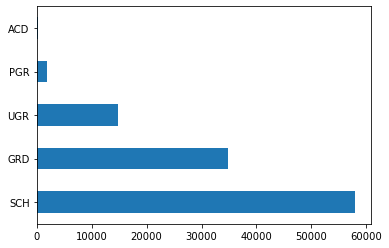

In [1235]:
data.education.value_counts().plot.barh()

In [1236]:
mode = data.education.mode()[0]
print('Самое частое значение в поле Education: ', mode)

Самое частое значение в поле Education:  SCH


In [1237]:
# Заполним пропуски в education модой

data['education'].fillna(mode, inplace=True)
data.education.unique()

array(['SCH', 'GRD', 'UGR', 'PGR', 'ACD'], dtype=object)

In [1238]:
# Проверим
data.education.value_counts()

SCH    58476
GRD    34768
UGR    14748
PGR     1865
ACD      291
Name: education, dtype: int64

### 4.2. Обработаем app_date

In [1239]:
data['app_date'] = pd.to_datetime(data.app_date, format='%d%b%Y')
data['app_date'].sample(5)

109104   2014-04-25
109146   2014-02-06
15791    2014-01-18
9666     2014-01-23
22090    2014-03-23
Name: app_date, dtype: datetime64[ns]

In [1240]:
data['app_date'].dt.year.value_counts()

2014    110148
Name: app_date, dtype: int64

Все заявки из датасета поданы в 2014 году.

In [1241]:
data['app_date'].dt.month.value_counts()

3    31597
2    27097
4    26266
1    25188
Name: app_date, dtype: int64

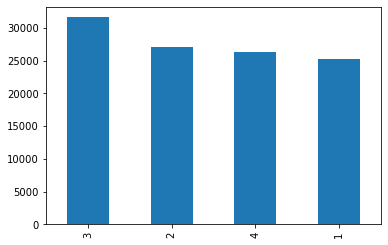

In [1242]:
data['app_date'].dt.month.value_counts().plot.bar()

Все заявки приблизительно равномерно распределены между 4 месяцами.

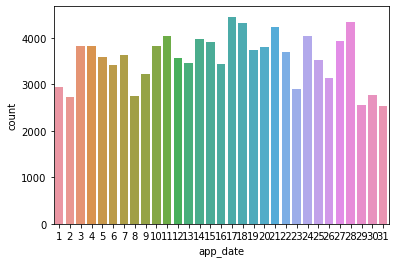

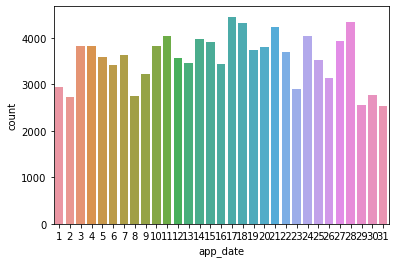

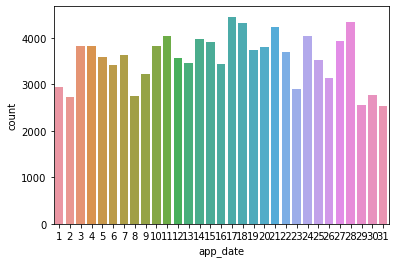

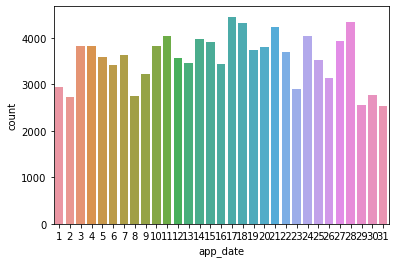

In [1243]:
data['month'] = data['app_date'].dt.month
for i in [1,2,3,4]:
    plt.figure()
    sns.countplot(x=data['app_date'].dt.day, data=data[data.month == i])
    plt.show()

Заявки по дням месяцев распределены приблизительно равномерно. Сильных перекосов нет.

Создадим новую переменную - количество дней от 01.01.2014.

In [1244]:
NY = pd.to_datetime('01/01/2014')
NY

Timestamp('2014-01-01 00:00:00')

In [1245]:
data['days_from_ny'] = (data['app_date'] - NY).dt.days
data[data.month == 1]['days_from_ny'].sample(5)

100135     9
105529    26
6126      22
36166     20
78696     22
Name: days_from_ny, dtype: int64

Итак, мы сконструировали новые признаки на основании app_data:
- month - месяц заявки
- days_from_ny - количество дней от 01.01.2014


Посмотрим на линейную зависимость между этими признаками

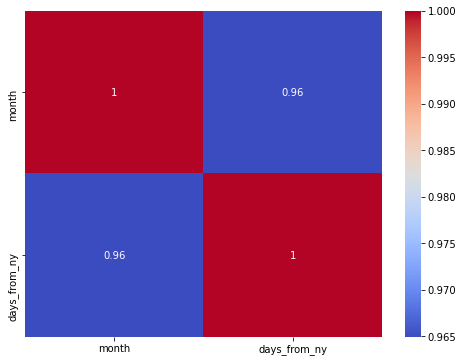

In [1246]:
fig, ax = plt.subplots(1,1, figsize = (8,6))
ax = sns.heatmap(data.loc[:,['month', 'days_from_ny']].corr(),annot = True, cmap = 'coolwarm')

Признаки очень сильно линейно-зависимы, поэтому один из них, month, мы использовать не будем.

In [1247]:
# Удалим из датасета признак app_date
data.drop(['app_date', 'month'],  axis = 1, inplace = True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   education         110148 non-null  object 
 2   sex               110148 non-null  object 
 3   age               110148 non-null  int64  
 4   car               110148 non-null  object 
 5   car_type          110148 non-null  object 
 6   decline_app_cnt   110148 non-null  int64  
 7   good_work         110148 non-null  int64  
 8   score_bki         110148 non-null  float64
 9   bki_request_cnt   110148 non-null  int64  
 10  region_rating     110148 non-null  int64  
 11  home_address      110148 non-null  int64  
 12  work_address      110148 non-null  int64  
 13  income            110148 non-null  int64  
 14  sna               110148 non-null  int64  
 15  first_time        110148 non-null  int64  
 16  foreign_passport  11

### 4.3. Обработаем числовые признаки

In [1248]:
# посмотрим на числовые признаки
# проверим, есть ли среди них категориальные
cols = data.columns
for col in cols:
    if data[col].dtype != 'O' and len(data[col].unique())<=20:
        print('Уникальные значения в поле {0} : {1}'.format(col,data[col].unique()))

Уникальные значения в поле good_work : [0 1]
Уникальные значения в поле region_rating : [50 80 60 40 70 20 30]
Уникальные значения в поле home_address : [1 2 3]
Уникальные значения в поле work_address : [2 3 1]
Уникальные значения в поле sna : [4 1 2 3]
Уникальные значения в поле first_time : [1 4 3 2]
Уникальные значения в поле default : [ 0.  1. nan]
Уникальные значения в поле Train : [1 0]


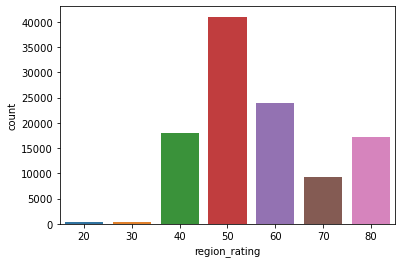

In [1249]:
sns.countplot(x=data['region_rating'], data=data)

Признак region_rating похож скорее на категориальный, чем на числовой. Обработаем его как категориальный.

In [1250]:
# Дополним бинарные и категориальные признаки
cat_cols += ['region_rating', 'home_address', 'work_address', 'sna', 'first_time']
bin_cols += ['good_work']

In [1251]:
# Посмотрим на признак client_id
data.client_id.astype('object').describe(include = 'object')

count     110148
unique    110148
top       110148
freq           1
Name: client_id, dtype: int64

Поле client_id - уникальный идентификатор клиента, не повторяется. Смысловой нагрузки не несет, можно выбросить из датасета.

In [1252]:
data.drop(['client_id'], axis = 1, inplace = True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   education         110148 non-null  object 
 1   sex               110148 non-null  object 
 2   age               110148 non-null  int64  
 3   car               110148 non-null  object 
 4   car_type          110148 non-null  object 
 5   decline_app_cnt   110148 non-null  int64  
 6   good_work         110148 non-null  int64  
 7   score_bki         110148 non-null  float64
 8   bki_request_cnt   110148 non-null  int64  
 9   region_rating     110148 non-null  int64  
 10  home_address      110148 non-null  int64  
 11  work_address      110148 non-null  int64  
 12  income            110148 non-null  int64  
 13  sna               110148 non-null  int64  
 14  first_time        110148 non-null  int64  
 15  foreign_passport  110148 non-null  object 
 16  default           73

In [1253]:
print('Бинарные признаки: ',bin_cols)
print('Категориальные признаки :',cat_cols)

Бинарные признаки:  ['sex', 'car', 'car_type', 'foreign_passport', 'good_work']
Категориальные признаки : ['education', 'region_rating', 'home_address', 'work_address', 'sna', 'first_time']


In [1254]:
# Выпишем числовые признаки

num_cols = set(data.columns) - set(bin_cols + cat_cols + ['default', 'Train'])
print('Числовые признаки: ', num_cols)

Числовые признаки:  {'score_bki', 'income', 'bki_request_cnt', 'age', 'days_from_ny', 'decline_app_cnt'}


In [1255]:
num_cols = list(num_cols)
num_cols

['score_bki',
 'income',
 'bki_request_cnt',
 'age',
 'days_from_ny',
 'decline_app_cnt']

#### 4.3.1. age

In [1256]:
# Построим графики для age
data_age = NumFitInspect(data[data.Train == 1], 'age')

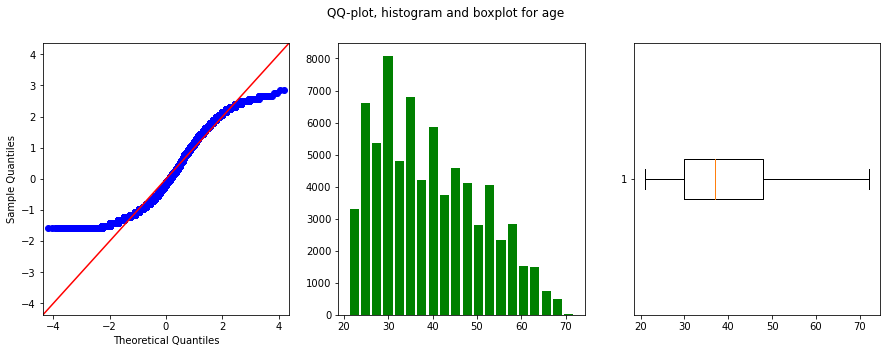

In [1257]:
data_age.show_plots()

Признак распределен нормально, выбросов нет.

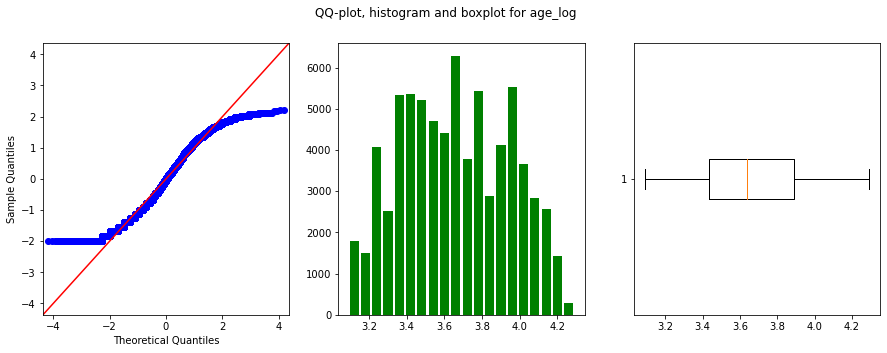

In [1258]:
# посмотрим на графики  log(age) 
data_age.show_plots(log = True)

После логарифмирования  признак age стал менее смещёнными. 

In [1259]:
# логарифмируем признак age
data['age'] = np.log(data['age'] + 1)
data['age'].sample(5)

5541     3.258097
64844    3.332205
37268    3.258097
43684    4.094345
66401    3.988984
Name: age, dtype: float64

***Заключение для age***: распределение нормальное, выбросов нет, взяли логарифм от признака

#### 4.3.2. decline_app_cnt

In [1260]:
# Построим графики для decline_app_cnt
data_decline_app_cnt = NumFitInspect(data[data.Train == 1], 'decline_app_cnt')

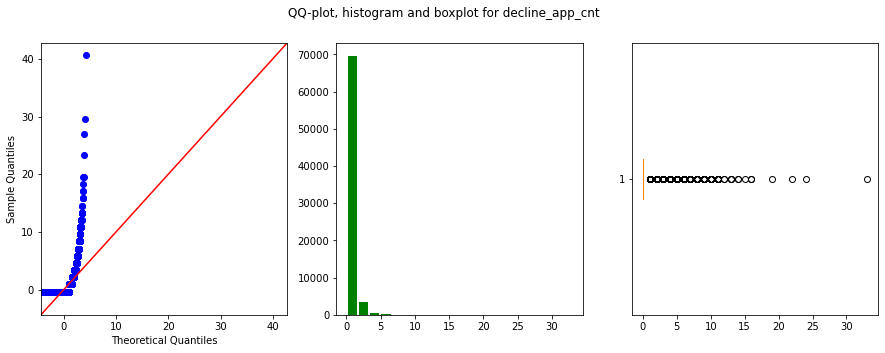

In [1261]:
data_decline_app_cnt.show_plots()

Мы наблюдаем сильное смещение. Применим логарифмирование и посмотрим, что получилось

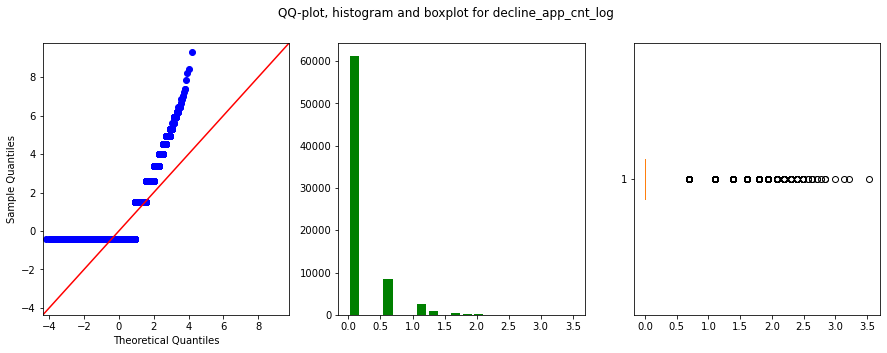

In [1262]:
data_decline_app_cnt.show_plots(log = True)

Очевидно, признак стал более нормальным. <br>
Посмотрим на выбросы.

In [1263]:
print('Суммарное количество выбросов для decline_app_cnt: ', data_decline_app_cnt.outliers())
print('Суммарное количество выбросов для log(decline_app_cnt): ', data_decline_app_cnt.outliers(log = True))

Суммарное количество выбросов для decline_app_cnt:  12585
Суммарное количество выбросов для log(decline_app_cnt):  12585


In [1264]:
data[data.decline_app_cnt < 2].decline_app_cnt.value_counts()

0    91471
1    12500
Name: decline_app_cnt, dtype: int64

Создадим на основании decline_app_cnt два новых признака:
- бинарный: были или не было отказов
- числовой: целое количество отказов

In [1265]:
data['decline_flag'] = data.decline_app_cnt.apply(lambda x: 0 if x < 1 else 1)
data['declines'] = data.decline_app_cnt.apply(lambda x: round(x))

In [1266]:
data['declines'].value_counts()

0     91471
1     12500
2      3622
3      1365
4       606
5       255
6       156
7        58
8        37
9        29
10       16
11       10
12        5
13        4
14        3
16        3
30        1
15        1
19        1
20        1
21        1
22        1
24        1
33        1
Name: declines, dtype: int64

In [1267]:
data['decline_flag'].value_counts()

0    91471
1    18677
Name: decline_flag, dtype: int64

In [1268]:
new_fits = ['decline_flag','declines']

In [1269]:
# логарифмируем признак decline_app_cnt
data['decline_app_cnt'] = np.log(data['decline_app_cnt'] + 1)
data['decline_app_cnt'].sample(5)

14308    0.000000
48966    0.693147
15796    0.000000
84042    0.000000
84113    0.000000
Name: decline_app_cnt, dtype: float64

***Заключение по decline_app_cnt*** : распределение нормальное, очень сильно смещенное (так, что даже логарифмирование это не особо исправило), взяли логарифм, выбросов очень много даже после логарифмирования, поэтому удалять их пока не будем. Посмотрим влияение выбросов на модель в дальнейшем. <br>
Создали на его основе два новых признака.

4.3.3. income

In [1270]:
# Построим графики для income
data_income = NumFitInspect(data[data.Train == 1], 'income')

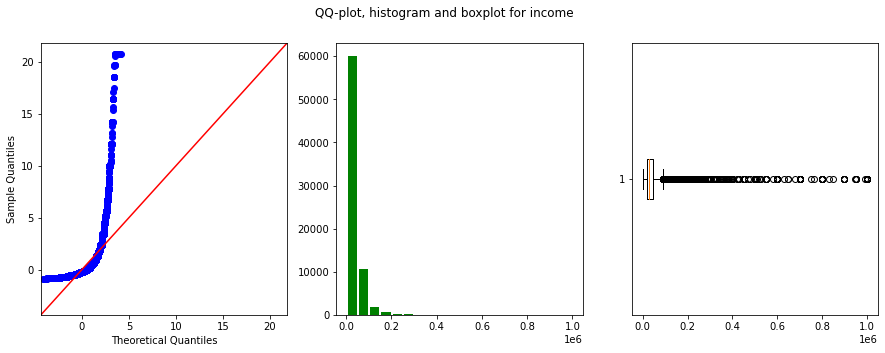

In [1271]:
data_income.show_plots()

Признак очень смещен. Много выбросов. <br> Посмотрим на log(income)

Посмотрим на распределение признака по региону

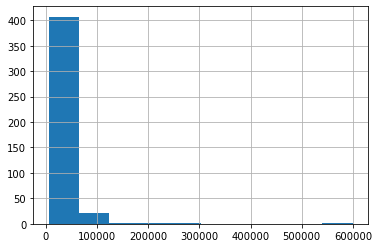

In [1272]:
data['income'][data['region_rating'] == 30].hist()

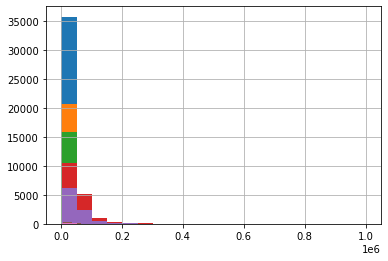

In [1273]:
# посмотрим на распределение признака в регионах
for x in data['region_rating'].value_counts().index:
    data['income'][data['region_rating'] == x].hist(bins=20)
plt.show()

В регионах также наблюдается очень сильное смещение. Создадим бинарный признак, показывающий, что значение сильно не типичное.

In [1274]:
p95_income = data.income.quantile(q = 0.95)
max_income = data.income.max()

data['large_income'] = data.income.apply(lambda x: 0 if x <= p95_income else 1)

data['large_income'].value_counts()

0    105483
1      4665
Name: large_income, dtype: int64

In [1275]:
new_fits += ['large_income']

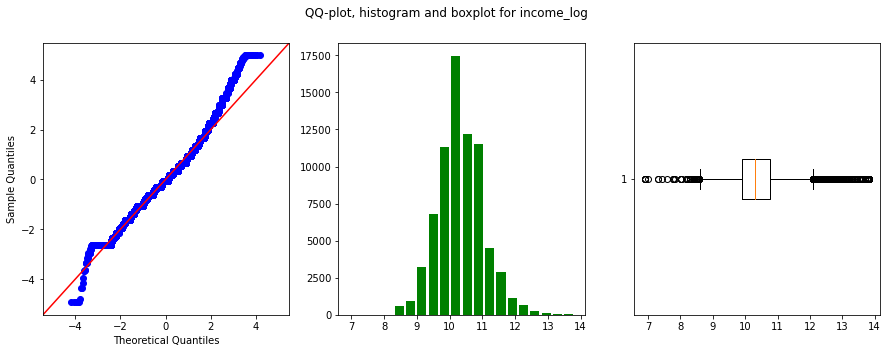

In [1276]:
data_income.show_plots(log = True)

После логарифмирования признак income стал гораздо более нормальным и менее смещёнными. <br>
Посмотрим на выбросы.

In [1277]:
print('Суммарное количество выбросов для income: ', data_income.outliers())
print('Суммарное количество выбросов для log(income): ', data_income.outliers(log = True))

Суммарное количество выбросов для income:  4695
Суммарное количество выбросов для log(income):  1767


После логарифмирования количество выбросов значительно уменьшилось.

In [1278]:
# логарифмируем признак income
data['income'] = np.log(data['income'] + 1)
data['income'].sample(5)

26010    10.596660
31383    10.819798
94839    10.819798
68146    10.126671
36056    10.126671
Name: income, dtype: float64

***Заключение по income*** : распределение нормальное, взяли логарифм, количестов выбросов после логарифмирования уменьшилось, поэтому удалять их пока не будем. Посмотрим влияение выбросов на модель в дальнейшем.

4.3.4. days_from_ny

In [1279]:
# Построим графики для income
data_days_from_ny = NumFitInspect(data[data.Train == 1], 'days_from_ny')

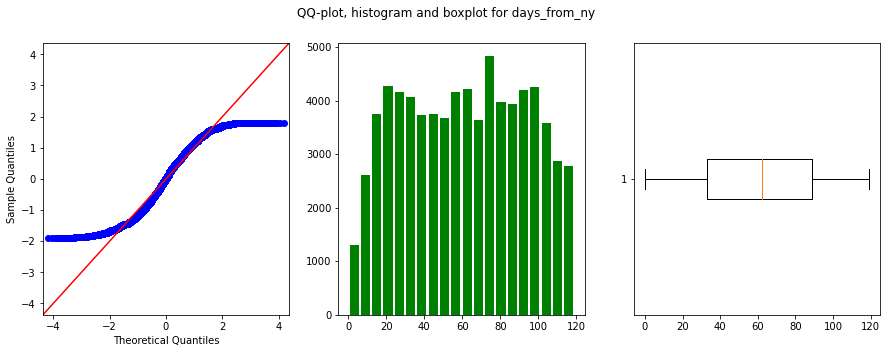

In [1280]:
data_days_from_ny.show_plots()

***Заключение по days_from_ny*** : признак распределен нормально. Выбросов нет. Логарифмировать не нужно.

4.3.5. bki_request_cnt

In [1281]:
# Построим графики для bki_request_cnt
data_bki_request_cnt = NumFitInspect(data[data.Train == 1], 'bki_request_cnt')

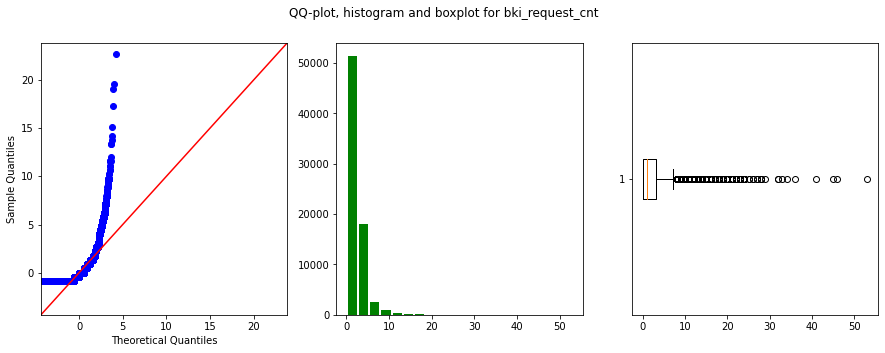

In [1282]:
data_bki_request_cnt.show_plots()

Признак очень смещен. Много выбросов. <br>
Логарифмируем признак.

Создадим на основе этого признака бинарный: больше или нет одного запроса в БКИ

In [1283]:
data.bki_request_cnt.value_counts()

0     28908
1     27295
2     20481
3     13670
4      8406
5      4960
6      2500
7      1292
8       735
9       459
10      350
11      278
12      217
13      151
14      110
15       81
16       58
17       33
18       32
19       30
21       19
20       14
23       12
24       12
22        8
25        5
27        5
28        5
26        4
32        4
29        3
33        2
40        2
41        1
46        1
45        1
47        1
36        1
34        1
53        1
Name: bki_request_cnt, dtype: int64

In [1284]:
data['requests_flag'] = data.bki_request_cnt.apply(lambda x: 0 if x < 1 else 1)

data['requests_flag'].value_counts()

1    81240
0    28908
Name: requests_flag, dtype: int64

In [1285]:
new_fits += ['requests_flag']

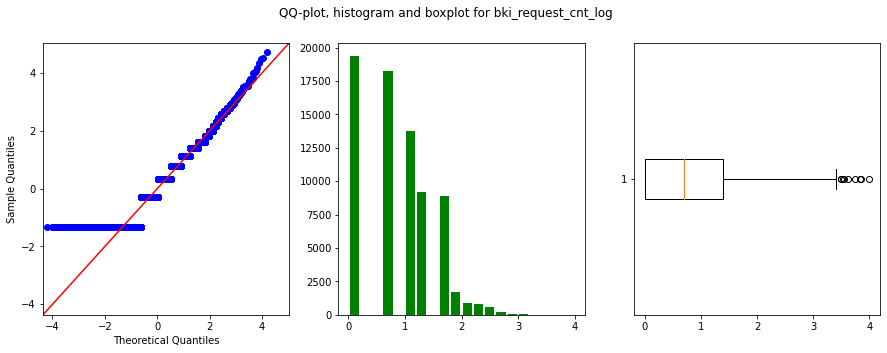

In [1286]:
data_bki_request_cnt.show_plots(log = True)

Очевидно, признак стал более нормальным. <br>
Посмотрим на выбросы.

In [1287]:
print('Суммарное количество выбросов для bki_request_cnt: ', data_bki_request_cnt.outliers())
print('Суммарное количество выбросов для log(bki_request_cnt): ', data_bki_request_cnt.outliers(log = True))

Суммарное количество выбросов для bki_request_cnt:  1755
Суммарное количество выбросов для log(bki_request_cnt):  9


Количество выбросов после логарифмирования существенно уменьшилось.

In [1288]:
# логарифмируем признак bki_request_cnt
data['bki_request_cnt'] = np.log(data.bki_request_cnt + 1)
data['bki_request_cnt'].sample(5)

101369    2.079442
80434     1.098612
5490      0.693147
93453     1.098612
14041     0.000000
Name: bki_request_cnt, dtype: float64

***Заключение по bki_request_cnt*** : распределение нормальное, взяли логарифм, количестов выбросов после логарифмирования существенно уменьшилось, не будем их удалять.

4.3.6. score_bki

In [1289]:
# Построим графики для score_bki
data_score_bki = NumFitInspect(data[data.Train == 1], 'score_bki')

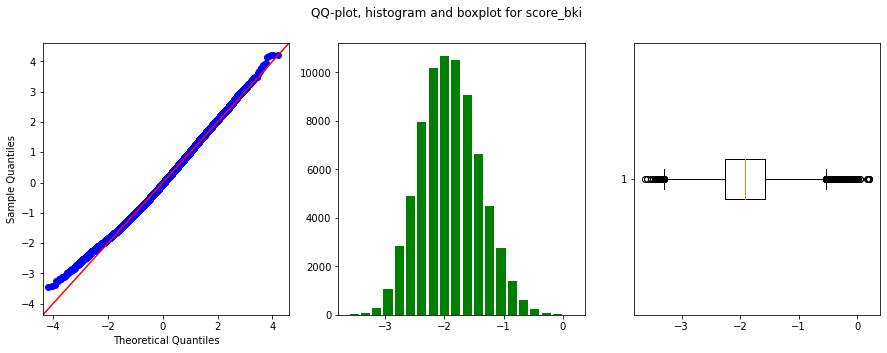

In [1290]:
data_score_bki.show_plots()

Распределение, очевидно, нормальное, не смещенное. Однако, есть выбросы.

Создадим новый признак - с помощью мат. преобразований попробуем немного его сгладить

In [1291]:
std = data.score_bki.std()
mean = data.score_bki.mean()
min = data.score_bki.min()

In [1292]:
data['score_bki_abslog'] = data.score_bki.apply(lambda x: np.abs(x - mean)**0.5) 

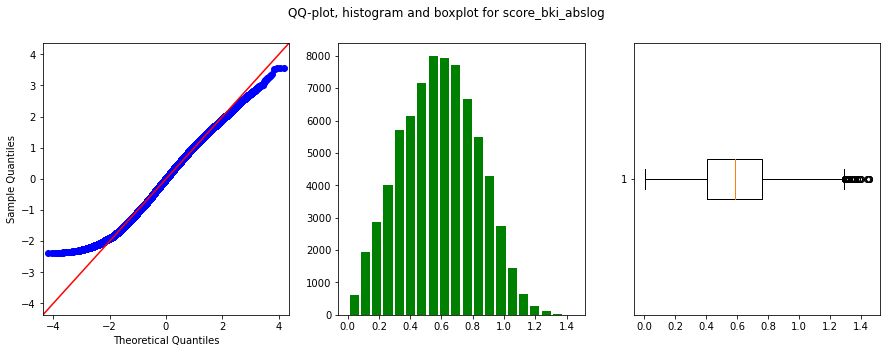

In [1293]:
NumFitInspect(data[data.Train == 1], 'score_bki_abslog').show_plots()

In [1294]:
print('Суммарное количество выбросов для score_bki: ', NumFitInspect(data[data.Train == 1], 'score_bki_abslog').outliers())

Суммарное количество выбросов для score_bki:  44


In [1295]:
new_fits +=['score_bki_abslog']

***Заключение по score_bki*** : распределение нормальное, не смещенное, логарифм брать не надо, выбросов относительно не много, не будем их удалять. Создали новый признак score_bki_abslog

Построим матрицу корреляции для числовых признаков num_cols

In [1296]:
new_nums = ['declines', 'score_bki_abslog']
new_bins = ['decline_flag', 'large_income', 'requests_flag']

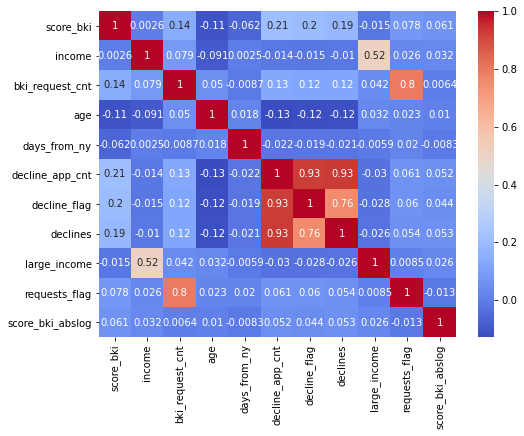

In [1297]:
fig, ax = plt.subplots(1,1, figsize = (8,6))
ax = sns.heatmap(data.loc[:,num_cols + new_fits].corr(),annot = True, cmap = 'coolwarm')


Очевидно, что новые признаки зависят от тех, на основании которых были созданы. Тем не менее, проверим, как на них работает модель. <br>
Посмотрим на значимость признаков для default

Значимость непрерывных переменных (на основе однофакторного дисперсионного анализа (ANOVA))
Для оценки значимости числовых переменных будем использовать функцию f_classif из библиотеки sklearn.

В качестве меры значимости мы будем использовать значение f -статистики. Чем значение статистики выше, тем меньше вероятность того, что средние значения не отличаются, и тем важнее данный признак для нашей линейной модели.

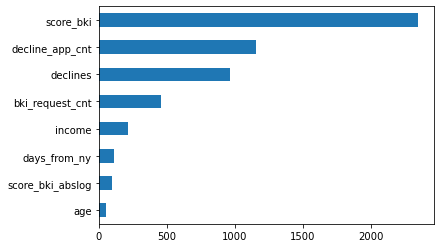

In [1298]:
imp_num = pd.Series(f_classif(data[data.Train == 1][num_cols + new_nums], data[data.Train == 1]['default'])[0], index = num_cols + new_nums)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

Новые признаки не значимы, не будем их использовать.

- наиболее значимый признак - score_bki;
- наименее значимый - age

Посмотрим, как распределены признаки относительно default

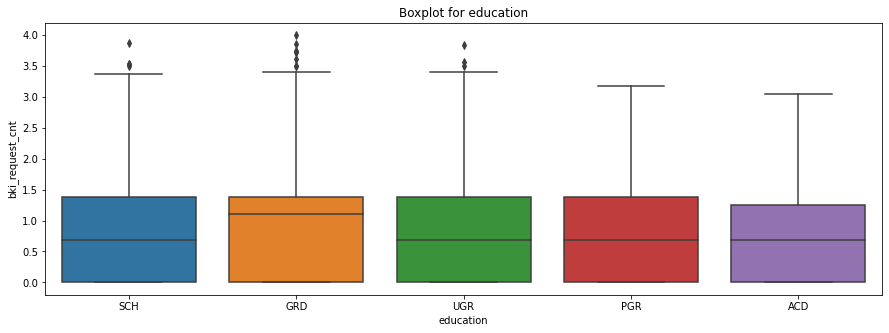

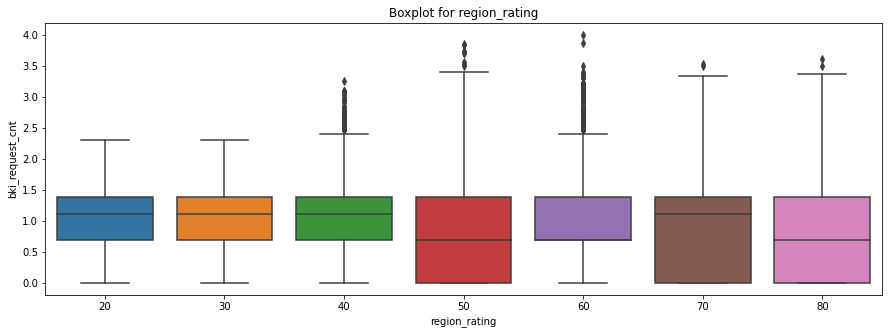

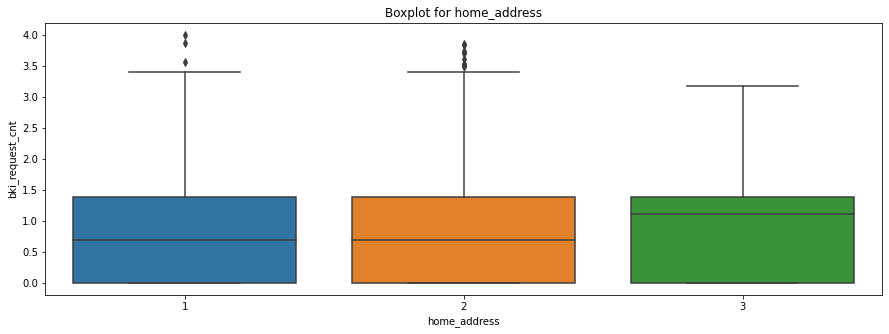

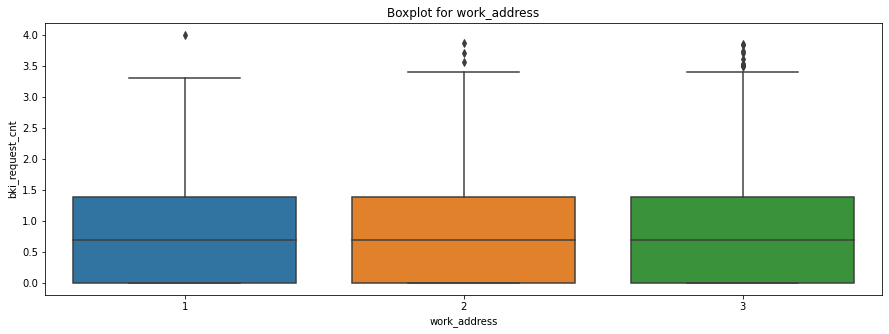

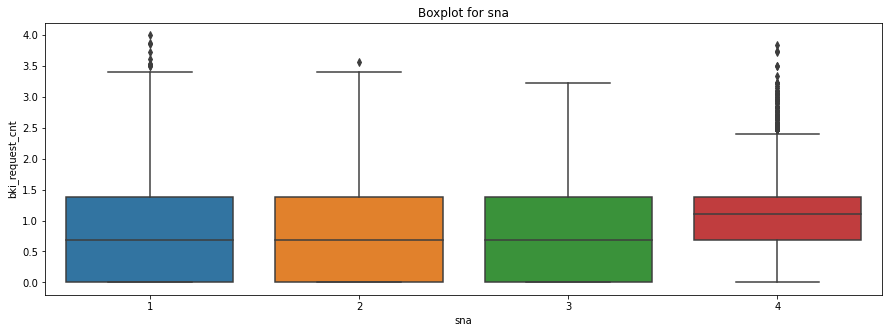

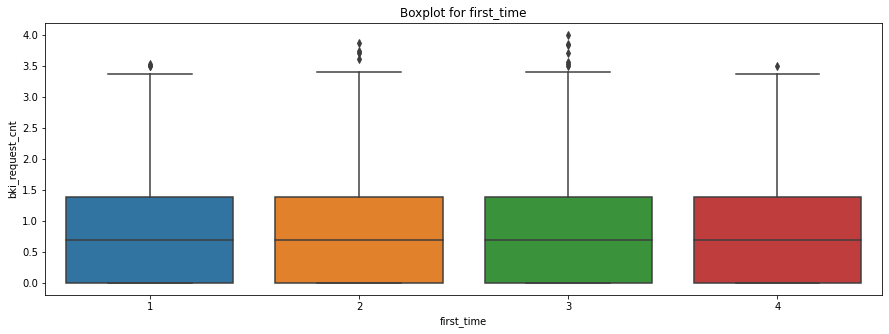

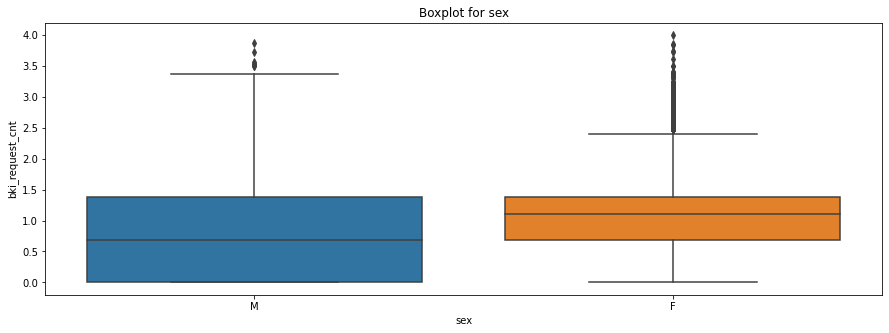

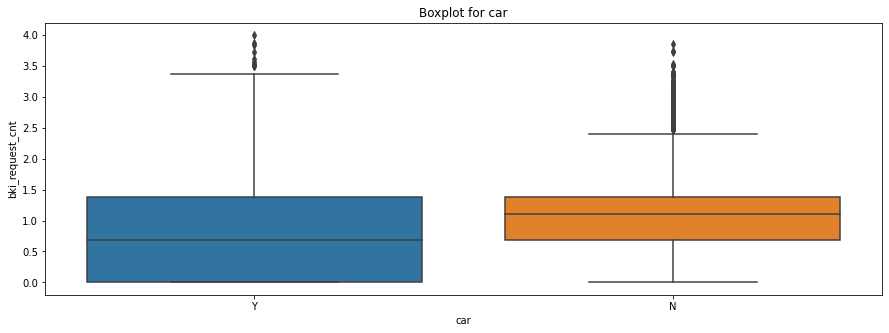

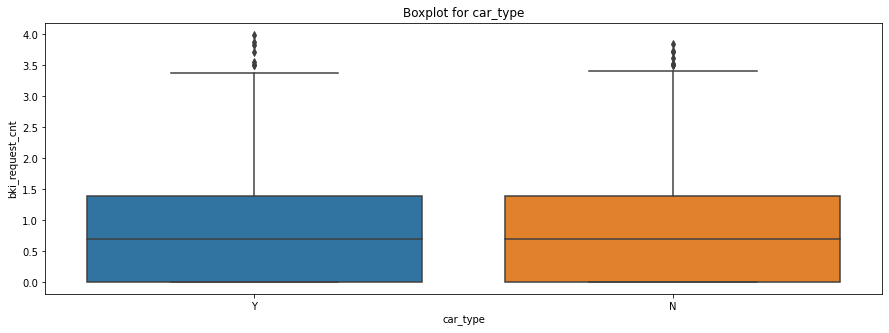

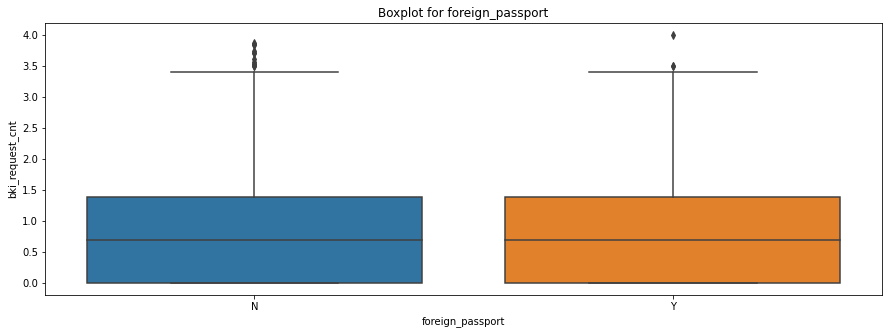

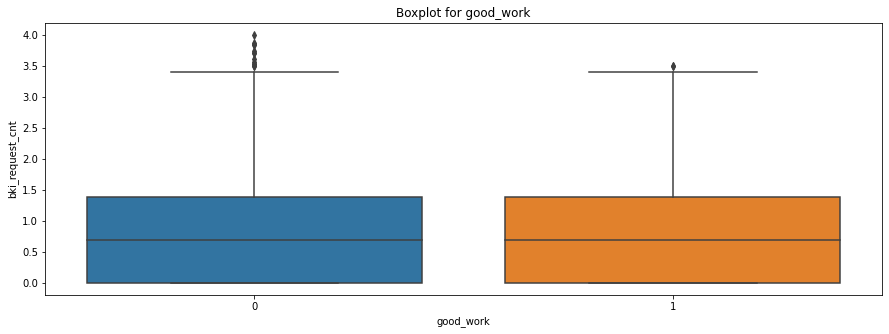

In [1299]:
for col in cat_cols + bin_cols:
    fig, ax = plt.subplots(figsize = (15, 5))
    sns.boxplot(x = col, y='bki_request_cnt', data = data, ax=ax)
    ax.set_title('Boxplot for {0}'.format(col))
    plt.show()

В разрезе всех категорий числовые признаки распределены крайне не равномерно. Обработать выбросы при помощи нормирования относительно категории не удастся.

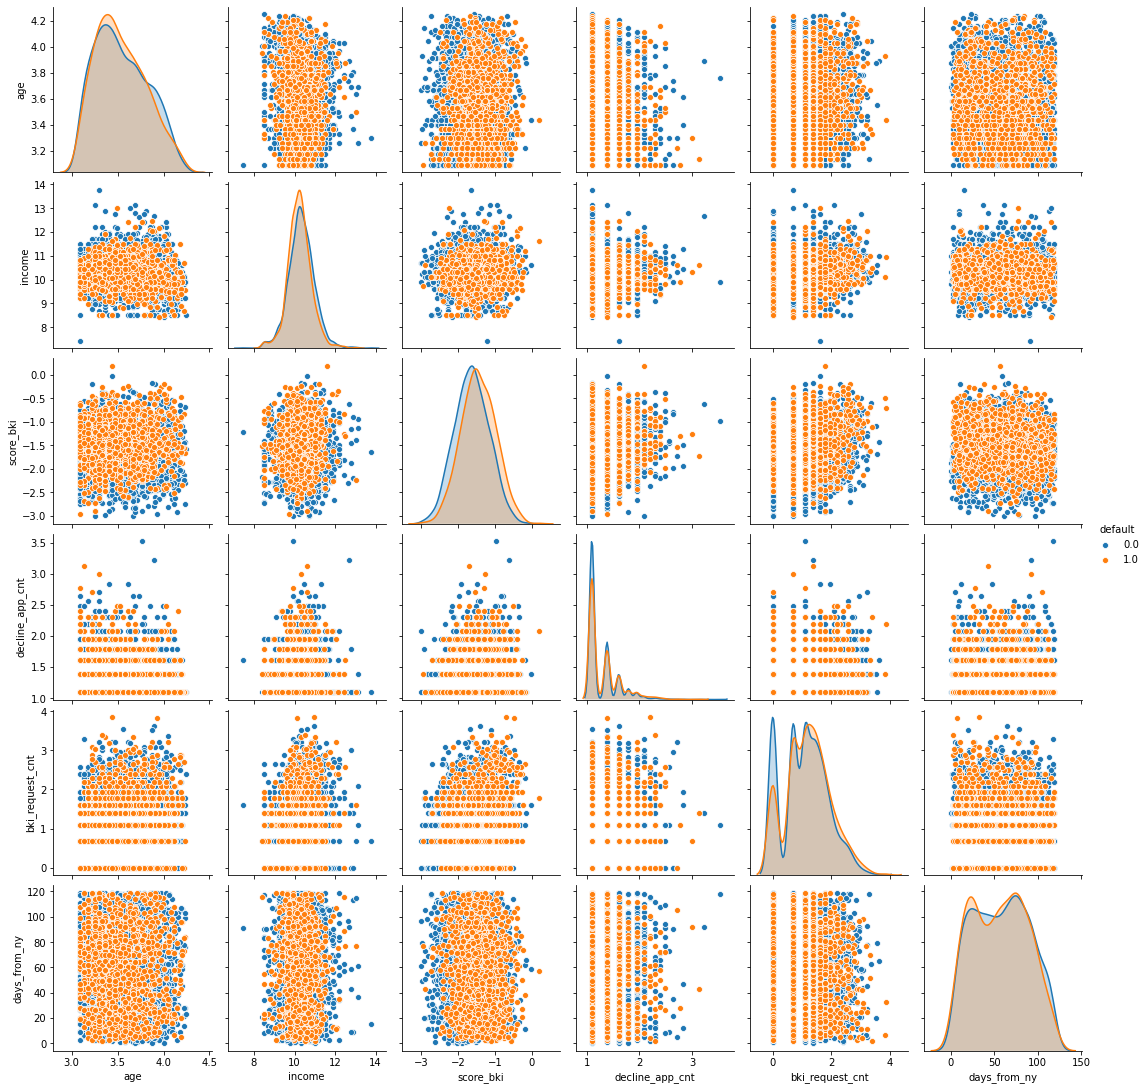

In [1300]:
sns.pairplot(data[data.Train == 1 & (data.decline_app_cnt > 1)].loc[:,['age','income','score_bki','decline_app_cnt','bki_request_cnt','days_from_ny','default']], hue = 'default')

Дефолты и не дефолты равномерно размазаны по признаками, выделить какую-то одну пару невозможно.

### 4.4. Обработаем категориальные и бинарные признаки

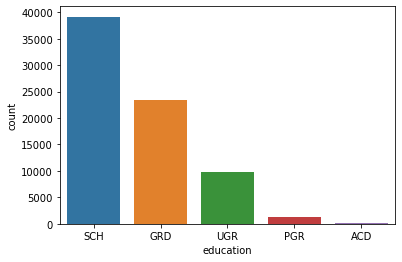

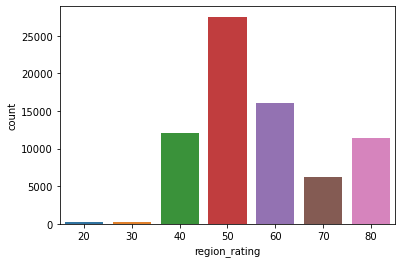

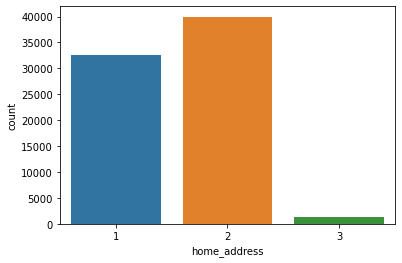

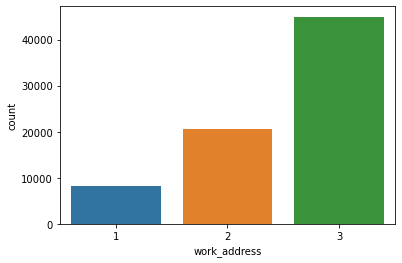

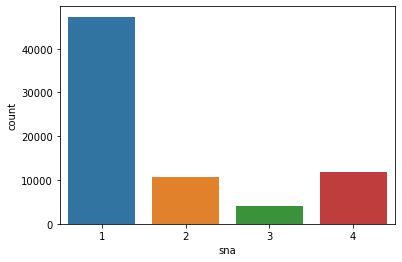

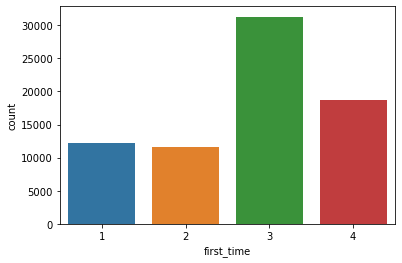

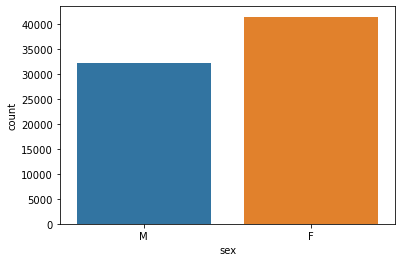

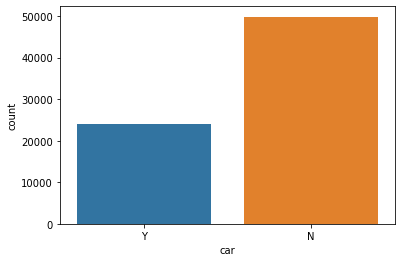

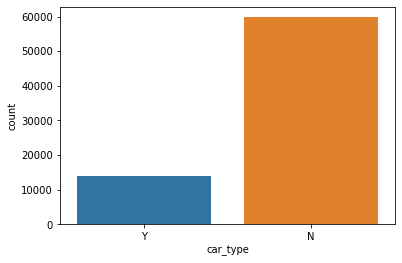

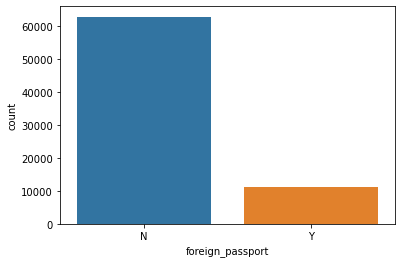

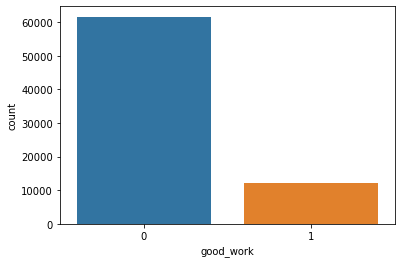

In [1301]:
for col in cat_cols + bin_cols:
    plt.figure()
    sns.countplot(x=col, data=data[data.Train == 1])
    plt.show()

Закодируем категориальные признаки education и region_rating и бинарные признаки

In [1302]:
# Преобразуем education в целочисленный формат
label_encoder = LabelEncoder()
data['education'] = label_encoder.fit_transform(data['education'])
data.education.unique()

array([3, 1, 4, 2, 0])

In [1303]:
# Закодируем region_rating
label_encoder = LabelEncoder()
data['region_rating'] = label_encoder.fit_transform(data['region_rating'])
data.region_rating.unique()

array([3, 6, 4, 2, 5, 0, 1])

In [1304]:
# Преобразуем биноминальные признаки
label_encoder = LabelEncoder()
for col in bin_cols:
    data[col] = label_encoder.fit_transform(data[col])
    
# убедимся в преобразовании    
data.head(5)

,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,...,first_time,foreign_passport,default,Train,days_from_ny,decline_flag,declines,large_income,requests_flag,score_bki_abslog
0,3,1,4.143135,1,1,0.000000,0,-2.008753,0.693147,3,...,1,0,0.0,1,31,0,0,0,1,0.322828
1,3,0,4.094345,0,0,0.000000,0,-1.532276,1.386294,3,...,1,0,0.0,1,70,0,0,0,1,0.610130
2,3,1,3.258097,1,0,1.098612,0,-1.408142,0.693147,6,...,4,1,0.0,1,31,1,2,0,1,0.704551
3,3,0,3.988984,0,0,0.000000,0,-2.057471,1.098612,3,...,3,0,0.0,1,22,0,0,0,1,0.391071
4,1,1,3.891820,0,0,0.000000,1,-1.244723,0.693147,4,...,4,1,0.0,1,107,0,0,0,1,0.812288


In [1305]:
# проверим
for column in bin_cols:
    print('Уникальные значения в поле {0} : {1}'.format(column,data[column].unique()))

Уникальные значения в поле sex : [1 0]
Уникальные значения в поле car : [1 0]
Уникальные значения в поле car_type : [1 0]
Уникальные значения в поле foreign_passport : [0 1]
Уникальные значения в поле good_work : [0 1]


Посмотрим на значимость категориальных признаков

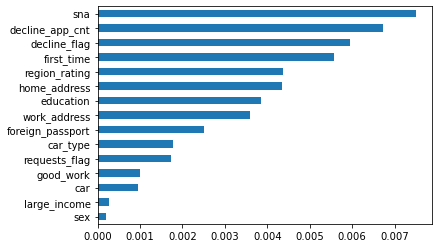

In [1306]:
imp_cat = pd.Series(mutual_info_classif(data[data.Train == 1][bin_cols + cat_cols + new_bins + ['decline_app_cnt']], data[data.Train == 1]['default'], 
                                     discrete_features =True), index = bin_cols + cat_cols + new_bins + ['decline_app_cnt'])
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

Мы видим, что новый признак decline_flag значим для default

- cамый значимый признак - sna;
- наименее значимый признак - sex

# 5. Подготовим данные к ML

In [1132]:
# закодируем категориальные признаки при помощи get_dummy
data_cat = pd.get_dummies(data.loc[:, cat_cols], columns = cat_cols)
data_cat.sample(3)

,education_0,education_1,education_2,education_3,education_4,region_rating_0,region_rating_1,region_rating_2,region_rating_3,region_rating_4,...,work_address_2,work_address_3,sna_1,sna_2,sna_3,sna_4,first_time_1,first_time_2,first_time_3,first_time_4
42020,0,0,0,1,0,0,0,0,1,0,...,1,0,0,0,0,1,1,0,0,0
100401,0,0,0,1,0,0,0,0,1,0,...,0,1,1,0,0,0,0,0,1,0
68785,0,0,0,1,0,0,0,0,1,0,...,0,0,0,1,0,0,0,1,0,0


In [1133]:
len(num_cols + cat_cols + bin_cols)

17

In [1168]:
# стандартизиуем числовые признаки
data_num = pd.DataFrame(StandardScaler().fit_transform(data[num_cols]), columns = num_cols)

data_declines = pd.DataFrame(StandardScaler().fit_transform(data.loc[:,['decline_flag']]), columns = ['decline_flag'])

In [1135]:
# объединим все признаки в один датасет

X = pd.concat([data_num, data_cat, data[bin_cols], data['Train'], data['default']], axis = 1)

Y = data['default'].values

Путем проверки, пришла к выводу, что новые признаки модель не улучшили. Убрала их.

In [1136]:
# проверим столбцы X
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 39 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   score_bki         110148 non-null  float64
 1   income            110148 non-null  float64
 2   bki_request_cnt   110148 non-null  float64
 3   age               110148 non-null  float64
 4   days_from_ny      110148 non-null  float64
 5   decline_app_cnt   110148 non-null  float64
 6   education_0       110148 non-null  uint8  
 7   education_1       110148 non-null  uint8  
 8   education_2       110148 non-null  uint8  
 9   education_3       110148 non-null  uint8  
 10  education_4       110148 non-null  uint8  
 11  region_rating_0   110148 non-null  uint8  
 12  region_rating_1   110148 non-null  uint8  
 13  region_rating_2   110148 non-null  uint8  
 14  region_rating_3   110148 non-null  uint8  
 15  region_rating_4   110148 non-null  uint8  
 16  region_rating_5   11

In [1137]:
# Проверим образец из трех строк
X.sample(3)

,score_bki,income,bki_request_cnt,age,days_from_ny,decline_app_cnt,education_0,education_1,education_2,education_3,...,first_time_2,first_time_3,first_time_4,sex,car,car_type,foreign_passport,good_work,Train,default
38069,-0.254535,0.529186,0.333797,-0.347997,0.219122,2.621662,0,0,0,1,...,0,0,1,1,1,0,0,0,1,0.0
32818,1.580271,1.675407,1.386150,0.903261,-0.965567,-0.418815,0,0,0,1,...,1,0,0,1,0,0,0,0,1,0.0
78941,-1.082697,0.430150,-1.334144,-0.449689,1.684395,-0.418815,0,0,0,0,...,1,0,0,1,0,0,0,0,0,NaN


# 6. Построим модель

#### Разобьем датасет на тренировочный и тестовый

In [1138]:
train_data = X.query('Train == 1').drop(['Train'], axis=1)
test_data = X.query('Train == 0').drop(['Train'], axis=1)

y = train_data.default.values            # целевая переменная
X = train_data.drop(['default'], axis=1)

#### Выделим из тренировочного датасета 20% на валидацию

In [1139]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

#### Проверим

In [1140]:
print(X.shape, X_train.shape, X_test.shape)

(73799, 37) (59039, 37) (14760, 37)


#### Обучим модель

In [1141]:
warnings.simplefilter('ignore')

model = LogisticRegression(random_state=RANDOM_SEED)
model.fit(X_train, y_train)

LogisticRegression(random_state=42)

Посмотрим на метрики.

In [1142]:
mi_1 = ModelInspect(model, X_test, y_test)

#### Построим ROC-кривую

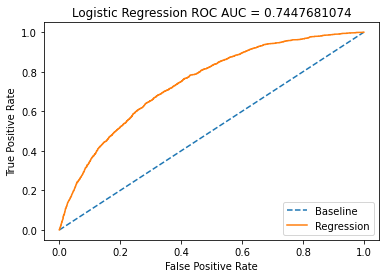

In [1143]:
mi_1.roc_curve_plot()

Метрика ROC_AUC - достаточно велика, то есть даже без глубокого отбора и конструирования признаков нам удалось построить модель, чья предсказательная сила заметно отличается от случайного угадывания.

#### Однако посмотрим на качественные метрики

In [1144]:
mi_1.get_metrics()

accuracy     0.874729
precision    0.394231
recall       0.022441
F1           0.042465
ROC_AUC      0.744768
dtype: float64

Confusion matrix

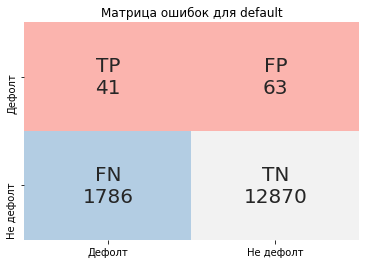

In [1145]:
mi_1.confusion_matrix_plot()

Кривая зависимости precision от recall

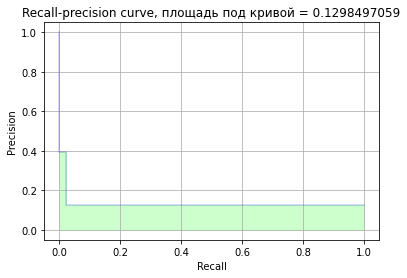

In [1146]:
mi_1.recall_precision_plot()

***Заключение по модели без регуляризации:*** не смотря на то, что значения ROC_AUC и accuracy достаточно высоки, значения recall и F1 показывают, что предсказательная способность низкая, ошибка второго рода (ложно отрицательные, дефолт классифицирован как не-дефолт) очень высока. Это означает, что при использовании такой модели банк может понести большие убытки. <br>
Попробуем:
- сбалансировать модель;
- применить регуляризацию.

# 7. Разберемся со сбалансированностью default

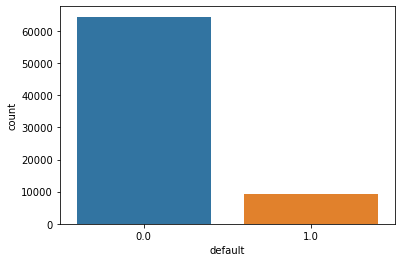

In [1147]:
ax = sns.countplot(x="default", data=data)

Выборка сильно не сбалансирована. <br>
Для сглаживания влияния несбалансированности применим параметр модели
- class_weight = 'balanced' - параметр для балансировки классов


In [1148]:
model = LogisticRegression(class_weight='balanced', random_state = RANDOM_SEED)
model.fit(X_train, y_train)
mi_balanced = ModelInspect(model, X_test, y_test)

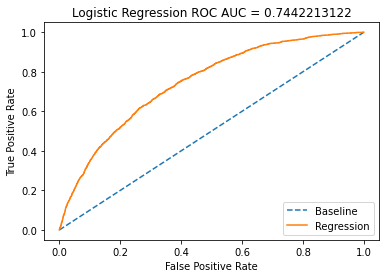

In [1149]:
mi_balanced.roc_curve_plot()

In [1150]:
mi_balanced.get_metrics()

accuracy     0.671070
precision    0.226715
recall       0.687466
F1           0.340980
ROC_AUC      0.744221
dtype: float64

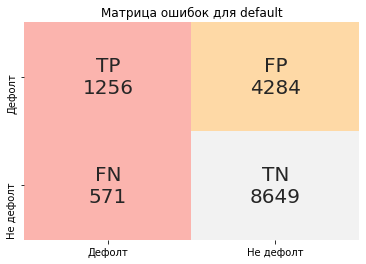

In [1151]:
mi_balanced.confusion_matrix_plot()

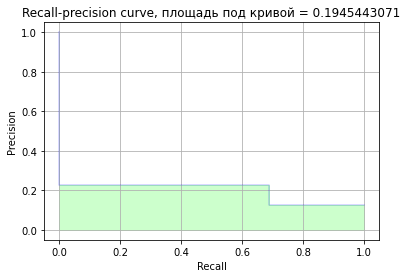

In [1152]:
mi_balanced.recall_precision_plot()

Мы видим, что после применения параметра балансировки, ошибка второго рода уменьшилась, метрики recall и f1 очень возрасли, это означает, что предсказание можели улучшилось. Однако очень сильно возрасла ошибка первого рода (не-дефолт классифицирован как дефолт). Это означает, что при применении такой модели банк рискует недополучить прибыль. Нужно найти золотую середину.

# 7.1. Проверим нулевые коэффициенты

При помощи l1 регуляризации проверим нулевые коэффициенты.

In [1153]:
model = LogisticRegression(random_state=RANDOM_SEED, 
                           C=1, 
                           class_weight= 'balanced', 
                           penalty= 'l1', 
                           solver = 'liblinear', 
                           )

model.fit(X_train, y_train)

LogisticRegression(C=1, class_weight='balanced', penalty='l1', random_state=42,
                   solver='liblinear')

In [1154]:
df_coef = pd.DataFrame(np.hstack((np.array(X_train.columns).reshape(37,1), model.coef_.reshape(37,1))), columns = ['col', 'coef'])

In [1155]:
df_coef['abs_coef'] = np.abs(df_coef.coef)
df_coef.sort_values(['abs_coef'], ascending = False)

,col,coef,abs_coef
17,region_rating_6,-0.859417,0.859417
6,education_0,-0.663982,0.663982
11,region_rating_0,0.58495,0.58495
16,region_rating_5,-0.532813,0.532813
0,score_bki,0.486223,0.486223
12,region_rating_1,0.471581,0.471581
8,education_2,-0.416151,0.416151
21,work_address_1,-0.301119,0.301119
24,sna_1,-0.291116,0.291116
31,first_time_4,-0.285947,0.285947


Нулевые коэффициенты означают, что признаки first_time_1, sna_2, region_rating_3, work_address_2 "не нравятся" модели, их вполне можно отбросить.

In [1156]:
cols_4del = ['first_time_1', 'sna_2', 'region_rating_3', 'work_address_2']

In [1157]:
X_train.drop(cols_4del, axis = 1, inplace = True)
X_test.drop(cols_4del, axis = 1, inplace = True)

Проверим модель:

In [1158]:
model = LogisticRegression(class_weight='balanced', random_state = RANDOM_SEED)
model.fit(X_train, y_train)
mi_drop0coef = ModelInspect(model, X_test, y_test)

In [1159]:
pd.concat([mi_balanced.get_metrics(),mi_drop0coef.get_metrics()], axis = 1)

,0,1
accuracy,0.671070,0.671070
precision,0.226715,0.226715
recall,0.687466,0.687466
F1,0.340980,0.340980
ROC_AUC,0.744221,0.744225


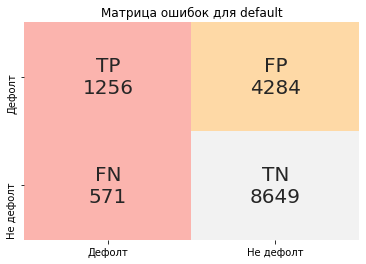

In [1160]:
mi_drop0coef.confusion_matrix_plot()

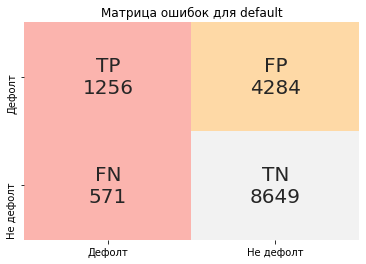

In [1161]:
mi_balanced.confusion_matrix_plot()

По матрице ошибок видим, что предсказание модели не изменилось. Однако AUC уменьшился.

In [645]:
np.logspace(-2, -1, 10)

array([0.01      , 0.0129155 , 0.01668101, 0.02154435, 0.02782559,
       0.03593814, 0.04641589, 0.05994843, 0.07742637, 0.1       ])

# 8. Подберем параметры модели

In [646]:
C = np.logspace(-2, -1, 10)
iter_ = 50
epsilon_stop = 1e-3
 
hyperparameters = [
    {'penalty': ['l1'], 
     'C': C,
     'solver': ['liblinear', 'saga'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['l2'], 
     'C': C,
     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['none'], 
     'C': C,
     'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['elasticnet'], 
     'C': C,
     'solver': ['saga'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
]

In [647]:
# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
# указываем модель (в нашем случае лог регрессия), гиперпараметры
model = LogisticRegression(class_weight = 'balanced', random_state = RANDOM_SEED)

In [648]:
# Обучаем модель
gridsearch = GridSearchCV(model, hyperparameters, scoring='f1', n_jobs=-1, cv=5)
gridsearch.fit(X_train, y_train)
model_best_params = gridsearch.best_estimator_

# Печатаем параметры
best_params = model_best_params.get_params()
print(f'Лучшие значения параметров:') 
for param_name in best_params.keys():
        print(f'  {param_name} = {best_params[param_name]},')

Лучшие значения параметров:
  C = 0.021544346900318832,
  class_weight = balanced,
  dual = False,
  fit_intercept = True,
  intercept_scaling = 1,
  l1_ratio = None,
  max_iter = 50,
  multi_class = auto,
  n_jobs = None,
  penalty = l2,
  random_state = 42,
  solver = liblinear,
  tol = 0.001,
  verbose = 0,
  warm_start = False,


Лучшие значения параметров:

 
   C = 0.021544346900318832,
  class_weight = balanced,
  dual = False,
  fit_intercept = True,
  intercept_scaling = 1,
  l1_ratio = None,
  max_iter = 50,
  multi_class = auto,
  n_jobs = None,
  penalty = l2,
  random_state = 42,
  solver = liblinear,
  tol = 0.001,
  verbose = 0,
  warm_start = False

Я довольно долго играла с подбором параметра: от слабой регуляризации с С>50 до очень сильной c C < 1. <br>
Решила остановиться на С = 0,0215. Но есть риск переобучения при такой сильной регуляризации, поэтому сделаем кросс-валидацию. 

In [649]:
mi_bestparams = ModelInspect(model_best_params, X_test, y_test)

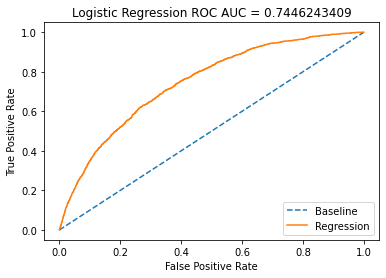

In [650]:
mi_bestparams.roc_curve_plot()

In [651]:
metrics = pd.concat([mi_drop0coef.get_metrics(), mi_bestparams.get_metrics()],axis = 1)
metrics.columns = ['last iter', 'best params']
metrics

,last iter,best params
accuracy,0.671070,0.671138
precision,0.226715,0.226756
recall,0.687466,0.687466
F1,0.340980,0.341026
ROC_AUC,0.744225,0.744624


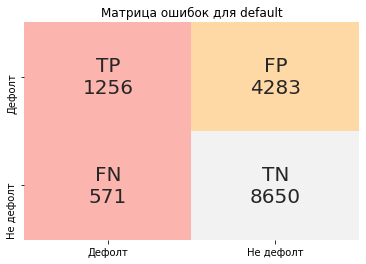

In [652]:
mi_bestparams.confusion_matrix_plot()

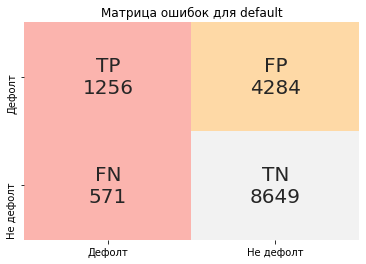

In [653]:
mi_drop0coef.confusion_matrix_plot()

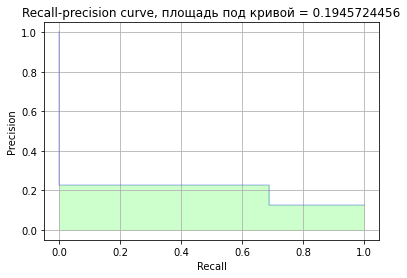

In [654]:
mi_bestparams.recall_precision_plot()

Сильная регуляризация при С = 0,0215 улучшила предсказание для клиентов, которым можно выдавать кредит (на 1 ложно-отрицательный стало меньше). Ну, тоже результат ).
Сделаем кросс-валидацию для параметров С.

## 8.1. Кросс-валидация

Так как мы применили сильную регуляризацию, то велик риск, что наша модель переобучилась, поэтому проведем кросс-валидацию

In [655]:
# заново собирем все признаки и разобьем датасет на тренировочную и тестовые выборки

X = pd.concat([data_num, data_cat, data[bin_cols + ['decline_flag']], data['Train'], data['default']], axis = 1)
Y = data['default'].values

train_data = X.query('Train == 1').drop(['Train'], axis=1)
test_data = X.query('Train == 0').drop(['Train'], axis=1)

y = train_data.default.values            
X = train_data.drop(['default'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

X_train.drop(cols_4del, axis = 1, inplace = True)
X_test.drop(cols_4del, axis = 1, inplace = True)

In [656]:
X.drop(cols_4del, axis = 1, inplace = True)

In [657]:
# обучим модели с подобранными параметрами

# без регуляризации
model0 = LogisticRegression(
  C = 1,
  class_weight = 'balanced',
  dual = False,
  fit_intercept = True,
  intercept_scaling = 1,
  l1_ratio = None,
  max_iter = 50,
  multi_class = 'auto',
  n_jobs = None,
  penalty = 'l2',
  random_state = 42,
  solver = 'liblinear',
  tol = 0.001,
  verbose = 0,
  warm_start = False
)

In [658]:
model1 = LogisticRegression(
C = 0.021544346900318832,
  class_weight = 'balanced',
  dual = False,
  fit_intercept = True,
  intercept_scaling = 1,
  l1_ratio = None,
  max_iter = 50,
  multi_class = 'auto',
  n_jobs = None,
  penalty = 'l2',
  random_state = 42,
  solver = 'liblinear',
  tol = 0.001,
  verbose = 0,
  warm_start = False
)

In [659]:
# испортируем библиотеку для kfold кросс-валидации 
from sklearn.model_selection import cross_val_score

In [660]:
# посчитаем метрику F1 для 10 фолдов.
scores0 = cross_val_score(model0, X, y, cv=10, scoring='f1')
scores1 = cross_val_score(model1, X, y, cv=10, scoring='f1')

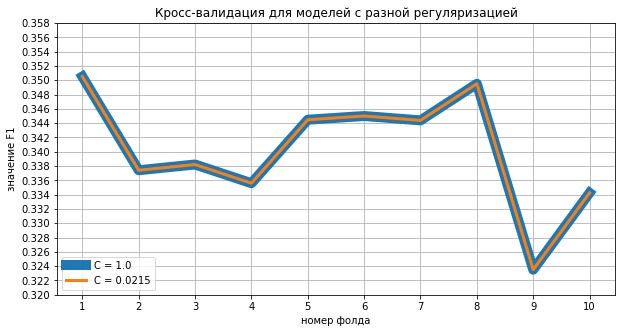

In [661]:
x = np.arange(1,11)

fig, ax = plt.subplots(1, 1, figsize = (10,5))
plt.plot(x, scores1, label = 'C = 1.0', linewidth=10)
plt.plot(x, scores1, label = 'C = 0.0215', linewidth=3)
plt.legend(loc = 'lower left')
plt.title('Кросс-валидация для моделей с разной регуляризацией')
plt.ylabel('значение F1')
plt.xlabel('номер фолда')
ax.set_xticks(x)
yticks = np.arange(0.32, 0.36, 0.002)
ax.set_yticks(yticks)
ax.grid(True)

Гипотеза о переобучении не подтвердилась. Регуляризация никак не повлияла на предсказание. Однако AUC подрос. Оставим для сэмпла С = 0.0215. При нем получается максимальный AUC на сэмпле, а у нас все-таки соревнование ).

## 8.2. LogisticRegressionCV

Попробуем применить LogisticRegressionCV для подбора оптимальных параметорв.

In [693]:
# заново собирем все признаки и разобьем датасет на тренировочную и тестовые выборки

X = pd.concat([data_num, data_cat, data[bin_cols], data['Train'], data['default']], axis = 1)
Y = data['default'].values

train_data = X.query('Train == 1').drop(['Train'], axis=1)
test_data = X.query('Train == 0').drop(['Train'], axis=1)

y = train_data.default.values            # целевая переменная
X = train_data.drop(['default'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

X_train.drop(cols_4del, axis = 1, inplace = True)
X_test.drop(cols_4del, axis = 1, inplace = True)

In [694]:
Cs_ = np.logspace(-3, 3, 100)

In [705]:
from sklearn.linear_model import LogisticRegressionCV

model = LogisticRegressionCV(
  Cs = Cs_,
  cv = 5,
  scoring = 'f1',
  solver = 'saga',
  tol = 0.001,
  max_iter = 50,   
  class_weight = 'balanced',
  n_jobs = -1,
  random_state = RANDOM_SEED,
  l1_ratios = np.linspace(0.01, 0.99, 10)
)

model.fit(X_train, y_train)

LogisticRegressionCV(Cs=array([1.00000000e-03, 1.14975700e-03, 1.32194115e-03, 1.51991108e-03,
       1.74752840e-03, 2.00923300e-03, 2.31012970e-03, 2.65608778e-03,
       3.05385551e-03, 3.51119173e-03, 4.03701726e-03, 4.64158883e-03,
       5.33669923e-03, 6.13590727e-03, 7.05480231e-03, 8.11130831e-03,
       9.32603347e-03, 1.07226722e-02, 1.23284674e-02, 1.41747416e-02,
       1.62975083e-02, 1.87...
       2.15443469e+02, 2.47707636e+02, 2.84803587e+02, 3.27454916e+02,
       3.76493581e+02, 4.32876128e+02, 4.97702356e+02, 5.72236766e+02,
       6.57933225e+02, 7.56463328e+02, 8.69749003e+02, 1.00000000e+03]),
                     class_weight='balanced', cv=5,
                     l1_ratios=array([0.01      , 0.11888889, 0.22777778, 0.33666667, 0.44555556,
       0.55444444, 0.66333333, 0.77222222, 0.88111111, 0.99      ]),
                     max_iter=50, n_jobs=-1, random_state=42, scoring='f1',
                     solver='saga', tol=0.001)

In [709]:
model.C_

array([0.0053367])

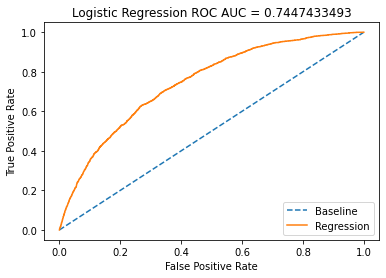

In [710]:
mi_CV = ModelInspect(model, X_test, y_test)
mi_CV.roc_curve_plot()

In [711]:
metrics = pd.concat([mi_bestparams.get_metrics(), mi_CV.get_metrics(), ],axis = 1)
metrics.columns = ['best params', 'CV']
metrics

,best params,CV
accuracy,0.671138,0.672696
precision,0.226756,0.227504
recall,0.687466,0.686371
F1,0.341026,0.341736
ROC_AUC,0.744624,0.744743


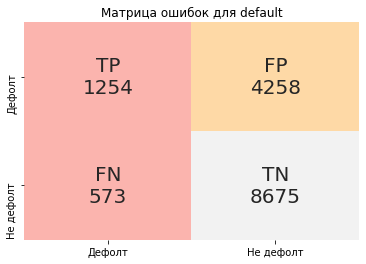

In [712]:
mi_CV.confusion_matrix_plot()

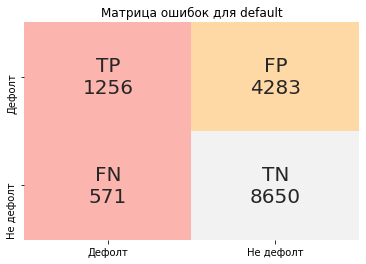

In [713]:
mi_bestparams.confusion_matrix_plot()

Применение LogisticRegressionCV улучшило предсказание модели: количество ложно-положительных (отказов) уменьшилось на 25, хотя количество ложно-отрицательных и выросло на 2, с бизнес-точки зрения, выгода от привлечения 25 клиентов может быть больше, чем убыток от двух.

# 9. Вывод
- Благодаря подбору параметров модели удалось улучшить recall в ~ 20 раз. <br>
- Ошибка второго рода уменьшилась, мы лучше стали определять дефолтных клиентов, однако очень сильно возрасла ошибка первого рода (не-дефолт классифицирован как дефолт). Это означает, что при применении такой модели банк рискует недополучить прибыль.
- Precision и F1 также увеличились. <br>
- Тем не менее, на метрику AUC подбор параметров особо не повлиял, очевидно, для несбалансированной выборки эта метрика не показательная. 

# Submission

In [1308]:
X = pd.concat([data_num, data_cat, data[bin_cols + ['decline_flag']], data['Train'], data['default']], axis = 1)

train_data = X.query('Train == 1').drop(['Train'], axis=1)
test_data = X.query('Train == 0').drop(['Train'], axis=1)

y_train = train_data.default.values 

X_train = train_data.drop(['default'], axis=1)
X_test = test_data.drop(['default'], axis=1)

In [1309]:
X_train.drop(cols_4del, axis = 1, inplace = True)
X_test.drop(cols_4del, axis = 1, inplace = True)

In [ ]:
'''
model = LogisticRegression(
  C = 0.021544346900318832,
  class_weight = 'balanced',
  dual = False,
  fit_intercept = True,
  intercept_scaling = 1,
  l1_ratio = None,
  max_iter = 50,
  multi_class = 'auto',
  n_jobs = None,
  penalty = 'l2',
  random_state = 42,
  solver = 'liblinear',
  tol = 0.001,
  verbose = 0,
  warm_start = False
)

model.fit(X_train, y_train)
'''

In [1310]:
model = LogisticRegressionCV(
  Cs = Cs_,
  cv = 5,
  scoring = 'f1',
  solver = 'saga',
  tol = 0.001,
  max_iter = 50,   
  class_weight = 'balanced',
  n_jobs = -1,
  random_state = RANDOM_SEED,
)

model.fit(X_train, y_train)

LogisticRegressionCV(Cs=array([1.00000000e-03, 1.14975700e-03, 1.32194115e-03, 1.51991108e-03,
       1.74752840e-03, 2.00923300e-03, 2.31012970e-03, 2.65608778e-03,
       3.05385551e-03, 3.51119173e-03, 4.03701726e-03, 4.64158883e-03,
       5.33669923e-03, 6.13590727e-03, 7.05480231e-03, 8.11130831e-03,
       9.32603347e-03, 1.07226722e-02, 1.23284674e-02, 1.41747416e-02,
       1.62975083e-02, 1.87...
       7.05480231e+01, 8.11130831e+01, 9.32603347e+01, 1.07226722e+02,
       1.23284674e+02, 1.41747416e+02, 1.62975083e+02, 1.87381742e+02,
       2.15443469e+02, 2.47707636e+02, 2.84803587e+02, 3.27454916e+02,
       3.76493581e+02, 4.32876128e+02, 4.97702356e+02, 5.72236766e+02,
       6.57933225e+02, 7.56463328e+02, 8.69749003e+02, 1.00000000e+03]),
                     class_weight='balanced', cv=5, max_iter=50, n_jobs=-1,
                     random_state=42, scoring='f1', solver='saga', tol=0.001)

In [1311]:
y_pred_prob = model.predict_proba(X_test)[:,1]

submit = pd.DataFrame(data_test.client_id)
submit['default']=y_pred_prob
submit.to_csv('submission.csv', index=False)

# 10. Попробуем выполнить oversampling

Попробуем решить проблему несбалансированных данных (default = 0 в разы больше, чем default = 1) при помощи метода oversampling — увеличение кол-ва объектов классов-меньшинств

Будем использовать для этого библиотеку imbalanced-learn

In [ ]:
import imblearn

In [ ]:
# заново собирем все признаки и разобьем датасет на тренировочную и тестовые выборки

X = pd.concat([data_num, data_cat, data[bin_cols], data['Train'], data['default']], axis = 1)
Y = data['default'].values

train_data = X.query('Train == 1').drop(['Train'], axis=1)
test_data = X.query('Train == 0').drop(['Train'], axis=1)

y = train_data.default.values            # целевая переменная
X = train_data.drop(['default'], axis=1)

Будем использовать Synthetic Minority Oversampling Technique (SMOTE) из библиотеки imblearn

In [ ]:
oversample = imblearn.over_sampling.SMOTE()
X, y = oversample.fit_resample(X, y)

In [ ]:
(X.shape, y.shape)

Посмотрим как стал распределен default

In [ ]:
print(len(y[y == 0]), len(y[y == 1]))

Мы видим, что теперь оба класса default = {0,1} распределены равномерно. <br>
Именно на этой выборке обучим модель.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle = True, random_state=RANDOM_SEED)

Обучим модель и посмотрим на метрики.

In [ ]:
model = LogisticRegression(random_state=RANDOM_SEED)
model.fit(X_train, y_train)
mi = ModelInspect(model, X_test, y_test)

In [ ]:
mi.roc_curve_plot()

In [ ]:
mi.get_metrics()

In [ ]:
mi.confusion_matrix_plot()

In [ ]:
mi.recall_precision_plot()

На oversampling датасете модель очень хорошо показала себя. Значения метрик очень высокие. Мы увидели, как важна сбалансированность признаков и насколько сильно это влияет на качество модели.

In [ ]:
# найдем нулевые коэффициенты

model = LogisticRegression(random_state=RANDOM_SEED, 
                           C=1, 
                           class_weight= 'balanced', 
                           penalty= 'l1', 
                           solver = 'liblinear', 
                           )

model.fit(X_train, y_train)

df_coef = pd.DataFrame(np.hstack((np.array(X_train.columns).reshape(37,1), model.coef_.reshape(37,1))), columns = ['col', 'coef'])

df_coef['abs_coef'] = np.abs(df_coef.coef)
df_coef.sort_values(['abs_coef'], ascending = False)

Нулевых коэффициентов нет.

Подберем параметры:

In [ ]:
C = np.logspace(-1, 3, 10)
iter_ = 50
epsilon_stop = 1e-3
 
hyperparameters = [
    {'penalty': ['l1'], 
     'C': C,
     'class_weight': ['None', 'balanced'],
     'solver': ['liblinear', 'saga'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['l2'], 
     'C': C,
     'class_weight': ['None', 'balanced'],
     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['none'], 
     'C': C,
     'class_weight': ['None', 'balanced'],
     'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['elasticnet'], 
     'C': C,
     'class_weight': ['None', 'balanced'],
     'solver': ['saga'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
]

model = LogisticRegression(random_state = RANDOM_SEED)

gridsearch = GridSearchCV(model, hyperparameters, scoring='f1', n_jobs=-1, cv=5)
gridsearch.fit(X_train, y_train)
model_best_params = gridsearch.best_estimator_

best_params = model_best_params.get_params()
print(f'Лучшие значения параметров:') 
for param_name in best_params.keys():
        print(f'  {param_name} = {best_params[param_name]},')

In [ ]:
mi_ovrs_bestparams = ModelInspect(model_best_params, X_test, y_test)

In [ ]:
mi_ovrs_bestparams.roc_curve_plot()

In [ ]:
mi_ovrs_bestparams.get_metrics()

In [ ]:
mi_ovrs_bestparams.confusion_matrix_plot()

Посмотрим, какие значения получим на тестовых данных

### Submission

In [ ]:
X_test = test_data.drop(['default'], axis=1)

y_pred_prob = model_best_params.predict_proba(X_test)[:,1]

submit = pd.DataFrame(data_test.client_id)
submit['default']=y_pred_prob


In [ ]:
submit.to_csv('submission_ovrs.csv', index=False)

Увы, на сэмпле модель показала значения метрик гораздо ниже, AUC  0.70. Скорее всего это означает, что данные в сэмпле также очень не сбалансированные и модель повела себя не адекватно.